# UCI Heart Disease - Exploratory Data Analysis

Conduct data exploration in the UCI Heart Disease dataset. The dataset contains 

Author: Joan Ponsa
Created on: 28.10.23
Last modified: 28.10.23

## Import Libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Set Working directory

## Variables

In [21]:
data_centers = ["cleveland", "hungarian", "switzerland", "va"]

In [22]:
original_dataset = "../Data/uci_heart_disease.original_processed.four_databases.tsv"
df = pd.read_csv(original_dataset, sep="\t")
df.head()

,data_center,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,cleveland,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,cleveland,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,cleveland,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,cleveland,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,cleveland,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


In [23]:
# create a binrary version of num variable
df["num_01"] = df["num"].apply(lambda x: 1 if x > 0 else 0)

## Missing values

Analysis of the missing value per data source. There are 4 data sources: Cleveland, Hungary, Long Bay VA and Switzerland.

- Total number of records per data source:
    Cleveland - 303 | Hungary = 294 | VA = 200 | Switzerland = 123

- Count the number of missing values per field (per each data source)
    Cleveland contains very few missing values. It makes sense as it has been used as reference dataset in many studies. However, it is surprising the number of missing value in the other data sources, especially VA. 

    - Conclusions:
        - Drop "cleveland" records containing NaN.
        - Use "cleveland" dataset to assess the importance of features "slope", "ca", "thal". If not particularly relevant, I will drop them as they contain large amount of missing value in the other datasets.
            See: 

        - Assess imputation of "chol", "fbs", and "trestbps"
    
        - Assess imputation of missing values for "chol", "fbs"

In [24]:
df.data_center.value_counts()

cleveland      303
hungarian      295
va             200
switzerland    123
Name: data_center, dtype: int64

<Axes: xlabel='num', ylabel='count'>

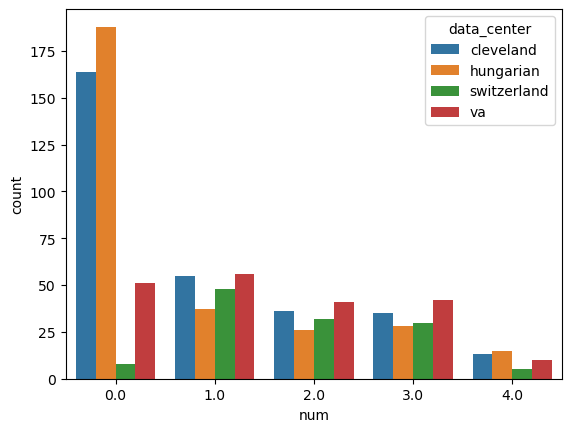

In [25]:
sns.countplot(data=df, x="num", hue="data_center")

<Axes: xlabel='num_01', ylabel='count'>

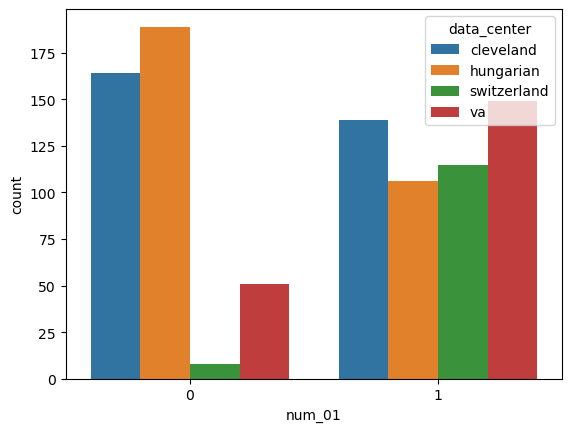

In [26]:
sns.countplot(data=df, x="num_01", hue="data_center")

Observation: Surprisingly Hungary did not report any disease class 2-4. However, when treating num as a binary variable (aka num_01) Hungary shows the same proportions asn Cleveland. Wondering whether hungary coded heart diseases only binary and not using the multi-class classification.

<Axes: xlabel='num', ylabel='count'>

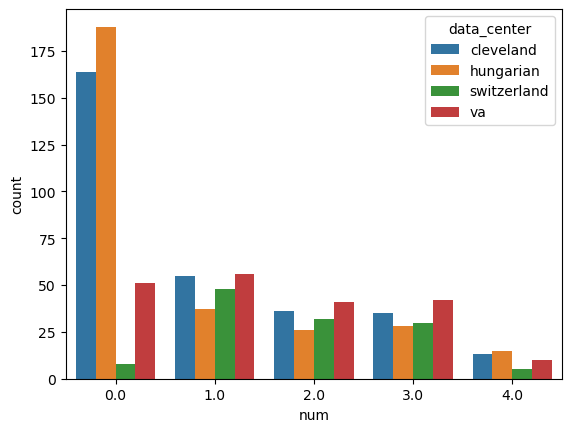

In [27]:
sns.countplot(data=df, x="num", hue="data_center")

In [28]:
def missing_valiues_plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    fig.suptitle("Missing values")

    missing_values_count = pd.DataFrame([], columns=data_centers, index=df.columns[1:])
    for center in data_centers:
        missing_values_count[center] = (
            df[df["data_center"] == center].isnull().sum(axis=0)[1:]
        )

    sns.heatmap(
        missing_values_count,
        annot=True,
        fmt=".4g",
        cmap="rocket_r",
        ax=ax1,
        vmin=0,
        vmax=300,
        cbar=False,
    )
    ax1.set_xlabel("data_center")

    missing_values_count = pd.DataFrame(
        [], columns=sorted(df.num.unique()), index=df.columns[1:]
    )
    for n in df.num.unique():
        missing_values_count[n] = df[df["num"] == n].isnull().sum(axis=0)[1:]

    sns.heatmap(
        missing_values_count,
        annot=True,
        fmt=".4g",
        cmap="rocket_r",
        ax=ax2,
        vmin=0,
        vmax=300,
    )
    ax2.set_xlabel("nums")

    plt.tight_layout()

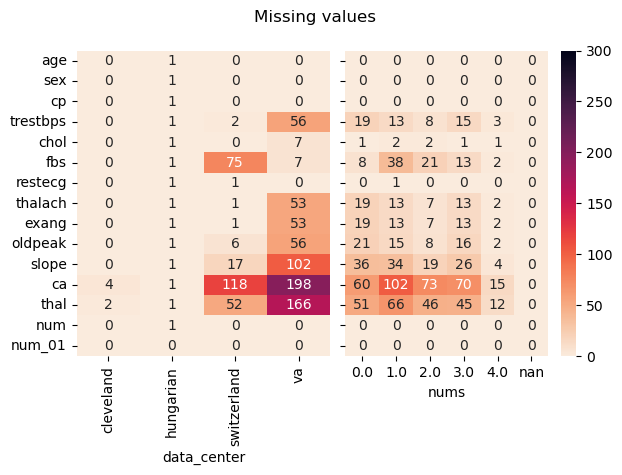

In [29]:
missing_valiues_plot()
plt.show()

# Feature Analysis

Analyse the "cleveland" subset as it will be use to perform a preliminary analysis of the feature importance.

the  key goal are:

(i) to understand the value distribution

(ii) identify any possible outliers

(iii) study the correlation between features 

In [30]:
# Select the "Cleveland" subset dropping reconds with missing values
cleveland = df[df["data_center"] == "cleveland"].dropna()

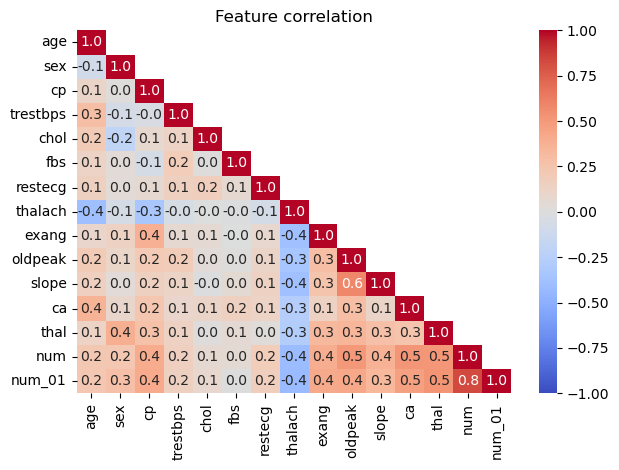

In [31]:
def correlation_plot():
    corr = cleveland.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr))
    np.fill_diagonal(mask, False)

    sns.heatmap(
        corr, cmap="coolwarm", annot=True, fmt=".1f", mask=mask, vmin=-1, vmax=1
    )
    plt.title("Feature correlation")
    plt.tight_layout()


correlation_plot()

Observation: Feature don't show a particular strong correlation between them.

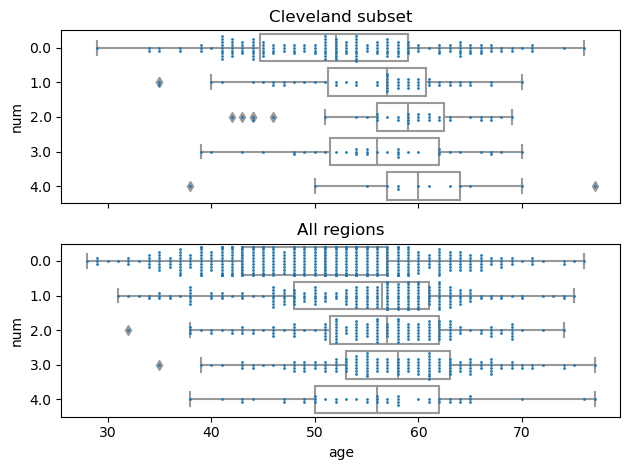

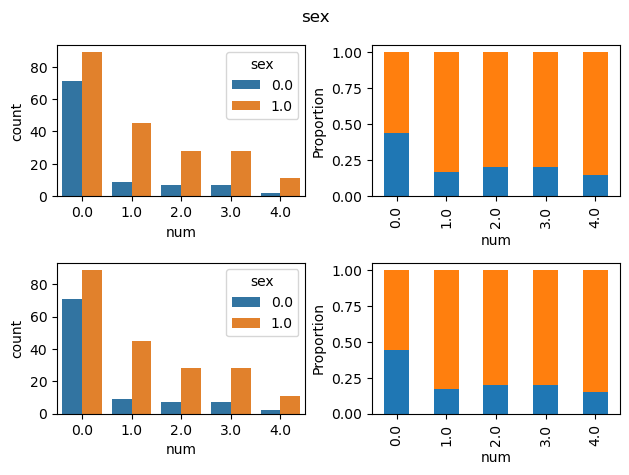

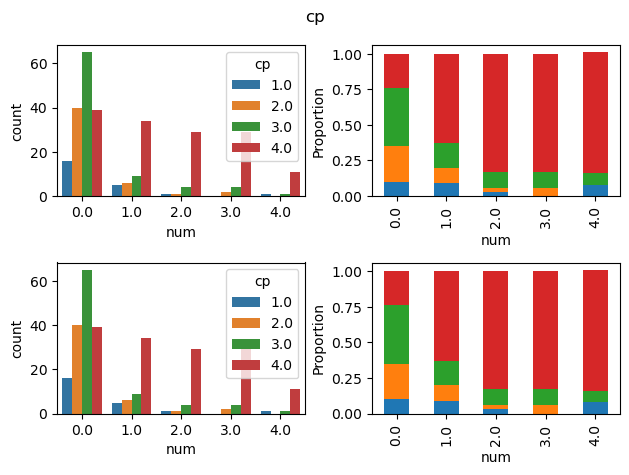

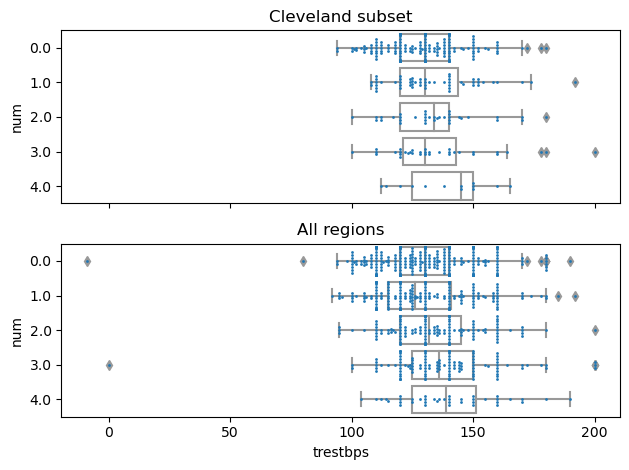

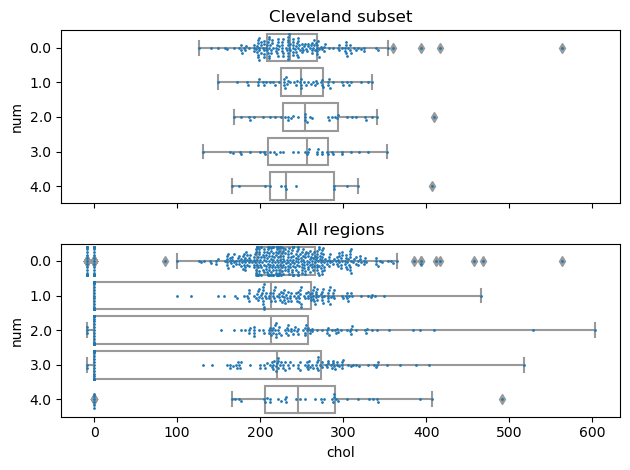

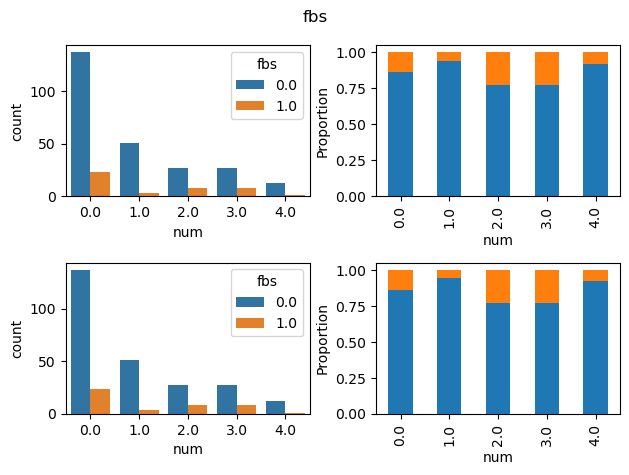

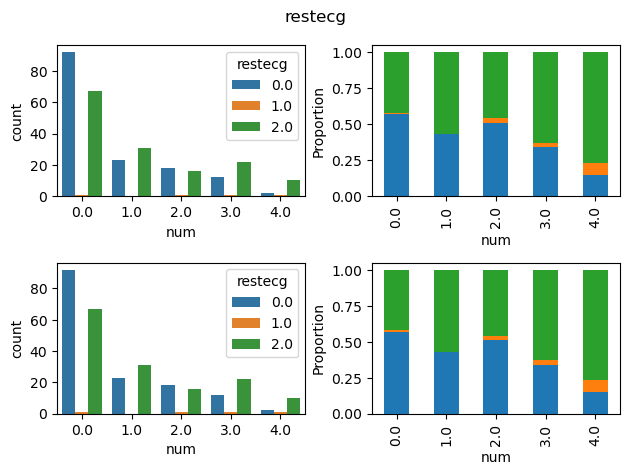

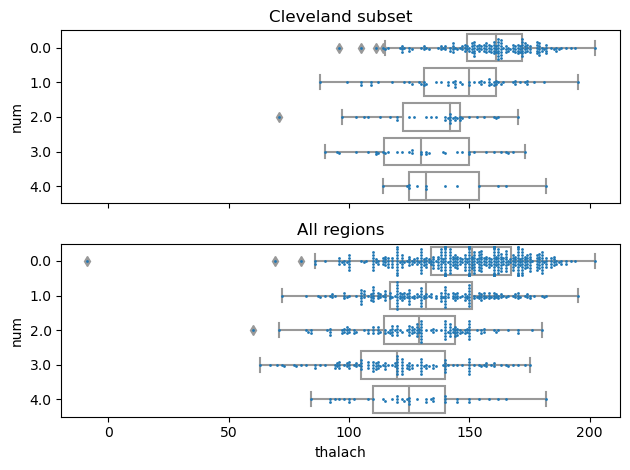

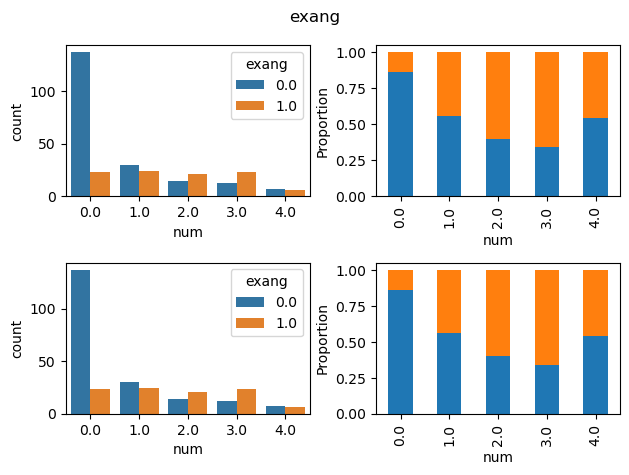

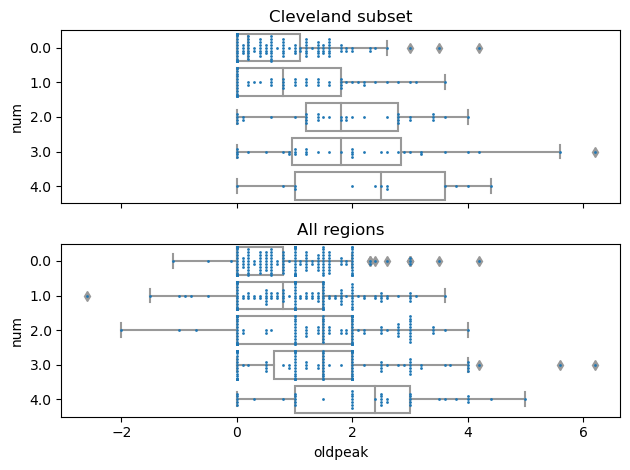

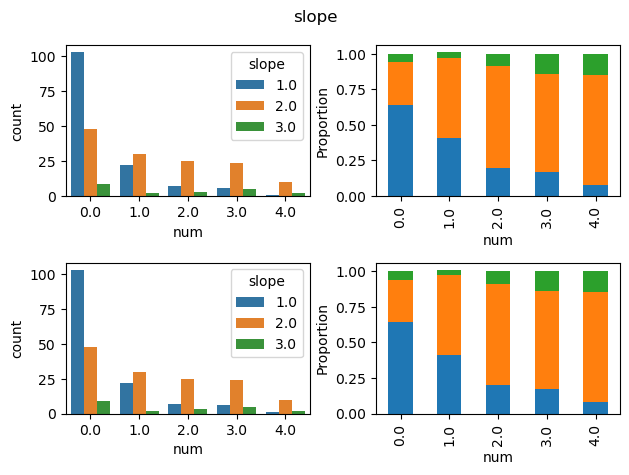

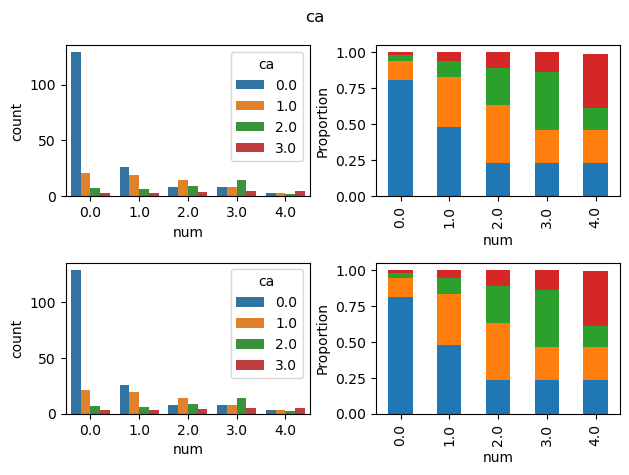

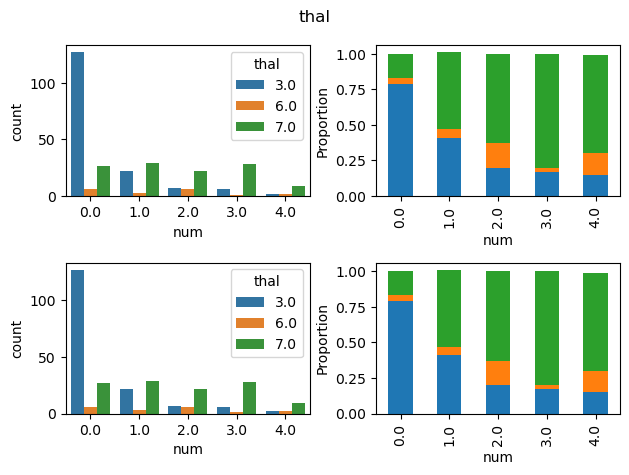

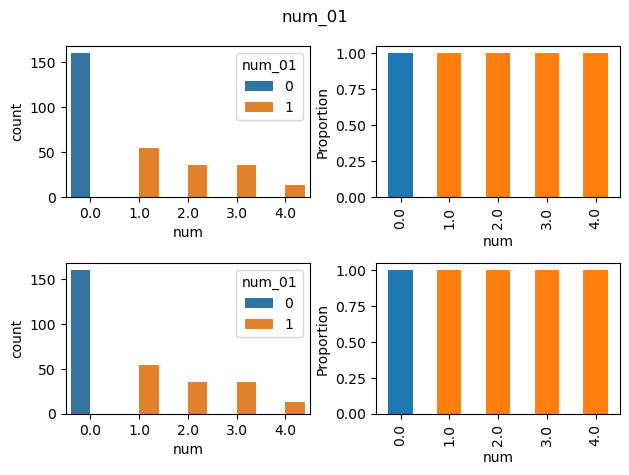

In [32]:
for f in cleveland.columns:
    if f in ["data_center", "num"]:
        continue

    if cleveland[f].value_counts().shape[0] > 5:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.set_title("Cleveland subset")
        sns.swarmplot(
            data=cleveland,
            y="num",
            x=f,
            ax=ax1,
            orient="horizontal",
            size=2,
            warn_thresh=1,
        )
        sns.boxplot(
            data=cleveland, y="num", x=f, color="1", ax=ax1, orient="horizontal"
        )

        ax2.set_title("All regions")
        sns.swarmplot(
            data=df, y="num", x=f, ax=ax2, orient="horizontal", size=2, warn_thresh=1
        )
        sns.boxplot(data=df, y="num", x=f, color="1", ax=ax2, orient="horizontal")

    else:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
        fig.suptitle(f)

        sns.countplot(data=cleveland, x="num", hue=f, ax=ax1)
        cleveland.groupby("num")[f].value_counts(normalize=True).round(
            2
        ).unstack().plot(kind="bar", stacked=True, ax=ax2)
        ax2.set_ylabel("Proportion")
        ax2.get_legend().remove()

        sns.countplot(data=cleveland, x="num", hue=f, ax=ax3)
        cleveland.groupby("num")[f].value_counts(normalize=True).round(
            2
        ).unstack().plot(kind="bar", stacked=True, ax=ax4)
        ax4.set_ylabel("Proportion")
        ax4.get_legend().remove()

    plt.tight_layout()
    plt.show()

### trestbps

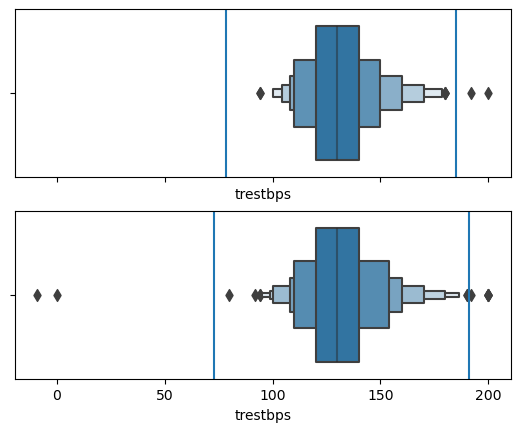

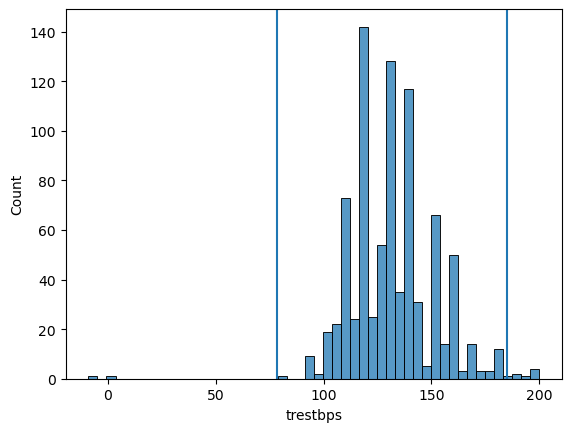

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sns.boxenplot(data=cleveland, x="trestbps", ax=ax1)
ax1.axvline(cleveland.trestbps.mean() - 3 * cleveland.trestbps.std())
ax1.axvline(cleveland.trestbps.mean() + 3 * cleveland.trestbps.std())

sns.boxenplot(data=df, x="trestbps", ax=ax2)
ax2.axvline(df.trestbps.mean() - 3 * df.trestbps.std())
ax2.axvline(df.trestbps.mean() + 3 * df.trestbps.std())

plt.show()

sns.histplot(data=df, x="trestbps")
plt.axvline(cleveland.trestbps.mean() - 3 * cleveland.trestbps.std())
plt.axvline(cleveland.trestbps.mean() + 3 * cleveland.trestbps.std())
plt.show()

Observation: threslbps zero values likely to be missing observations. Replace with NaN 

### chol

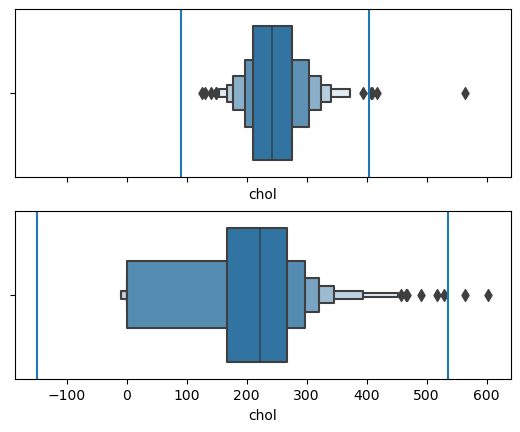

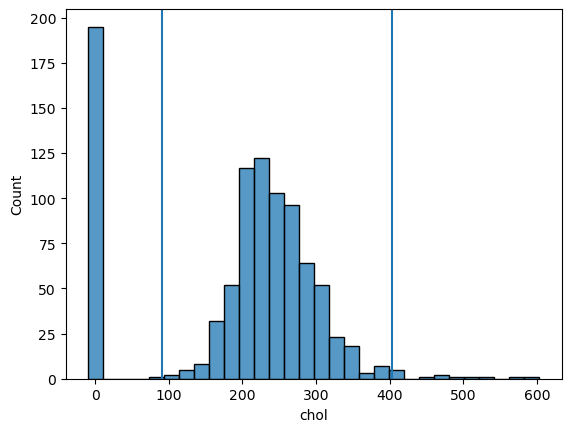

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sns.boxenplot(data=cleveland, x="chol", ax=ax1)
ax1.axvline(cleveland.chol.mean() - 3 * cleveland.chol.std())
ax1.axvline(cleveland.chol.mean() + 3 * cleveland.chol.std())

sns.boxenplot(data=df, x="chol", ax=ax2)
ax2.axvline(df.chol.mean() - 3 * df.chol.std())
ax2.axvline(df.chol.mean() + 3 * df.chol.std())
plt.show()

sns.histplot(data=df, x="chol")
plt.axvline(cleveland.chol.mean() - 3 * cleveland.chol.std())
plt.axvline(cleveland.chol.mean() + 3 * cleveland.chol.std())
plt.show()

Observation:
- chol zero values likely to be missing observations. Replace with NaN 
- chol values above 400 are outliers. Replace with 401

In [35]:
df.loc[df["chol"] == 0, "chol"] = np.nan

Re-analyse the number of missing values after 

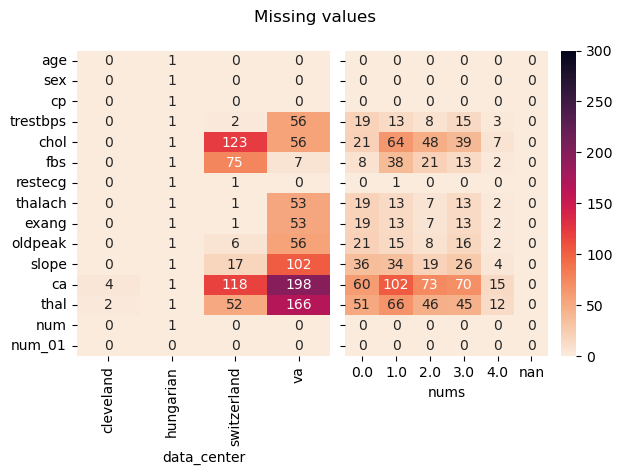

In [36]:
missing_valiues_plot()
plt.savefig("../Figures/10.missing_values.png")

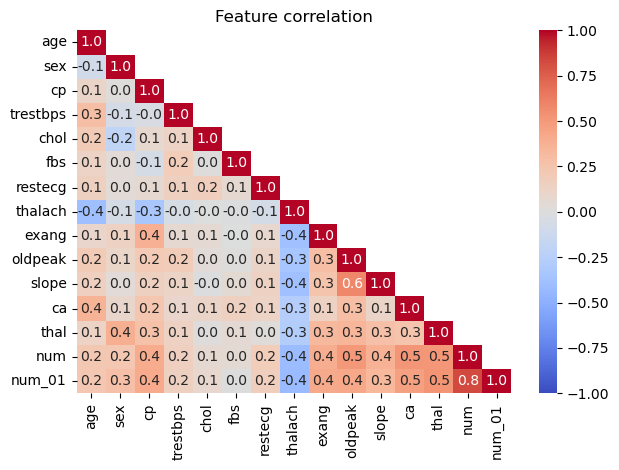

In [37]:
correlation_plot()
plt.savefig("../Figures/10.feature_correlation.png")

### oldpeak

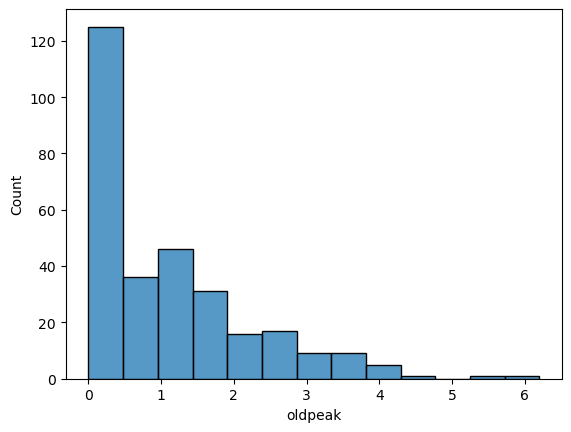

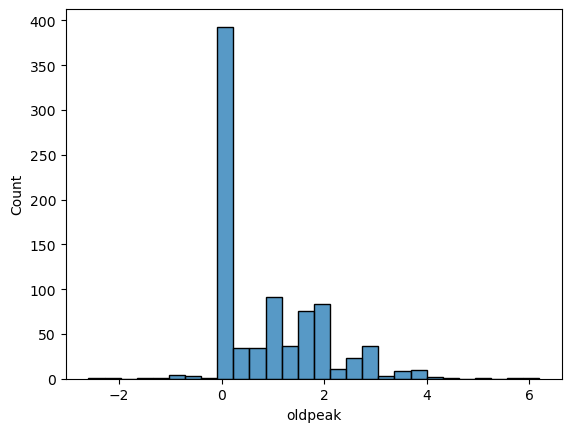

In [38]:
sns.histplot(data=cleveland, x="oldpeak")
plt.show()
sns.histplot(data=df, x="oldpeak")
plt.show()
# plt.axvline(cleveland.chol.mean() - 3 * cleveland.chol.std())
# plt.axvline(cleveland.chol.mean() + 3 * cleveland.chol.std())
plt.show()

Observation: I believe "oldpeak" values make no sense. Replace them with NaN